Execution for house price estimation

In [1]:
# Import relevant files and libraries
import DataProcessor
import sys
import LRegression
import NLRegression
import performance_metrics
import Kmeans


Define the parameters



In [2]:
# Allocate 80% of data to training
train_size = 0.8

# Identify features to be used
columnsToKeep = ['Price','Type','Bedroom','Bathroom','Car','Landsize','BuildingArea','Latitude','Longitude']
#columnsToKeep = ['Price', 'Bedroom', 'Bathroom']
#columnsToKeep = ['Price', 'Type', 'Landsize', 'BuildingArea']

featuresToTrain = ['Price', 'Type', 'Landsize','BuildingArea']

# Path to dataset.
filepath = '../dataset/Melbourne_housing_FULL.csv'

# Identify prediction (ground truth)
prediction_column = 'Price'

Process raw data

In [3]:
# Create a DataProcessor object and load the data
dp_obj = DataProcessor.DataProcessor()
dp_obj.LoadData(filepath)

# Remove incomplete points, remove unused features and shuffle the data
dp_obj.keepSelectedColumns(columnsToKeep)
dp_obj.filterData()
dp_obj.shuffleData()
dp_obj.reduceDataSize(1000)

print(dp_obj.data.head())


# Split the data into training and testing
train_X, train_Y, test_X, test_Y = dp_obj.splitData(train_size, prediction_column)

Data Processor object created
       Price Type  Bedroom  Bathroom  Car  Landsize  BuildingArea  Latitude  \
0  2600000.0    h      4.0       2.0  2.0     527.0         184.0 -37.88300   
1   732000.0    h      3.0       1.0  1.0     904.0         110.0 -37.80100   
2   450000.0    h      4.0       2.0  0.0     668.0         146.0 -37.56509   
3   773000.0    h      4.0       1.0  2.0     333.0         137.0 -37.78930   
4   561000.0    u      2.0       1.0  1.0    2571.0          66.0 -37.81980   

   Longitude   Size  
0  145.00430  527.0  
1  145.02970  904.0  
2  144.72563  668.0  
3  144.88180  333.0  
4  145.00500   66.0  
training size 800
test size 200


In [4]:
# test get average function in dataProcessing
print(dp_obj.getAverage('Landsize'))
print(dp_obj.getAverage('BuildingArea'))

560.332
146.29148999999998


K-Means Clustering

In [119]:
# Ashton
k = 5
pref = 'Size'
kmeans = Kmeans.Kmeans(train_X, train_Y, k, pref)

train_X, points, centroids = kmeans.cluster()

#plotKmean(train_X, points, centroids) 

KeyError: 5

Linear Regression

In [57]:
# Train
lr = LRegression.LRegression()
y_pred = lr.LinReg(features=train_X,target=train_Y,assignment=assignment)

NameError: name 'assignment' is not defined

In [ ]:
# Test


Non-Linear Regression (Gaussian Processing)

In [65]:
# Train
nlr = NLRegression.NLRegression(train_X, train_Y, test_X, test_Y, featuresToTrain)
nlr.train()

ValueError: could not convert string to float: 'u'

In [46]:
# Test
nlr.evaluate()

R² Score: 0.09592465565196084


0.09592465565196084

       x          y     y_pred     sigma
0    3.0   740000.0   925696.0  0.000001
1    3.0   569000.0   925696.0  0.000001
2    3.0  1140000.0  1101824.0  0.000001
3    3.0   942500.0   925696.0  0.000001
4    3.0  1116000.0   925696.0  0.000001
..   ...        ...        ...       ...
195  2.0   875000.0   774144.0  0.000001
196  3.0   485500.0   925696.0  0.000001
197  2.0   860000.0   935936.0  0.000002
198  3.0  1400000.0   925696.0  0.000001
199  5.0   945000.0  1721344.0  0.000003

[200 rows x 4 columns]


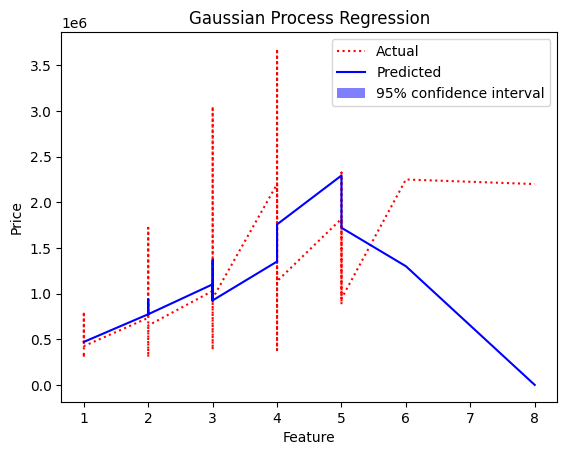

In [47]:
# plotting predictions vs expected
nlr.plot()

Evaluation Metrics

In [ ]:
# Wajeeha

User input for preference

In [6]:
# Dwelling type
type = input("What type of dwelling would you prefer? Either 'u' for unit or 'h' for house")
# Number of bedrooms
bedrooms = input("How many bedrooms would you prefer?")
# Number of bathrooms
bathrooms = input("How many bathrooms would you prefer?")
# Number of car parking spaces
car = input("How many car parking spaces would you prefer?")
# Size of land
size = input("What size would you prefer?")
# Latitude
latitude = input("Would you prefer 'east' or 'west'?")
# Longitude
longitude = input("Would you prefer 'north' or 'south'?")

# print(dp_obj.getAverage('Landsize'))
# print(dp_obj.getAverage('BuildingArea'))

Final prediction

In [ ]:
# Return predicted value from best performing model
targets = [type,bedrooms,bathrooms,car,size,latitude,longitude]
pred = lr.predict(features=targets)